# `VC` Práctica 3. Redes neuronales convolucionales (Parte 1: Apartados 1 y 2)

> Alumno: Miguel Ángel Fernández Gutiérrez
>
> Correo: [mianfg@correo.ugr.es](mailto:mianfg@correo.ugr.es)
> 
> Grupo: VC1

In [ ]:
%matplotlib inline

# Generales
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Keras
import keras.utils.np_utils as np_utils

# Tensorflow
#from tensorflow import logging

# Modelos y capas
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import BatchNormalization
from keras import Model, Input

# Optimizador
from tensorflow.keras.optimizers import SGD, Adam

# Función de pérdida
from keras.losses import categorical_crossentropy

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

# Conjunto de datos y preprocesamiento
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator

# ResNet
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

En el siguiente bloque de código, aparecen funciones auxiliares que serán usadas en esta práctica. Muchas de ellas usan el código proporcionado por los profesores de la asignatura.

In [ ]:
def _calcular_accuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmax(preds, axis = 1)
    
    accuracy = sum(labels == preds)/len(labels)
    
    return accuracy

def _mostrar_evolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(loss)
    ax1.plot(val_loss)
    ax1.legend(['Training', 'Validation'])
    ax1.title.set_text('Loss')

    ax2.plot(acc)
    ax2.plot(val_acc)
    ax2.legend(['Training', 'Validation'])
    ax2.title.set_text('Accuracy')

    plt.show()

def _mostrar_evoluciones(hist_dict):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.title.set_text('Loss')
    ax2.title.set_text('Accuracy')
    color = plt.cm.rainbow(np.linspace(0, 1, len(hist_dict.keys())))
    legend = []

    i = 0
    for h in hist_dict.keys():
        ax1.plot(hist_dict[h].history['loss'], linestyle='dashed', c=color[i])
        ax1.plot(hist_dict[h].history['val_loss'], c=color[i])
        ax2.plot(hist_dict[h].history['acc'], linestyle='dashed', c=color[i])
        ax2.plot(hist_dict[h].history['val_acc'], c=color[i])
        legend += [f'Training {h}', f'Validation {h}']
        i += 1

    ax1.legend(legend)
    ax2.legend(legend)
    plt.show()

def _leer_imagenes(vec_imagenes, path):
    clases = np.array([img.split('/')[0] for img in vec_imagenes])
    imagenes = np.array([img_to_array(load_img(path + "/" + img, target_size = (224, 224))) 
                           for img in vec_imagenes])
    return imagenes, clases
    
def _cargar_dataset(name, n_classes=25):
    if name == 'cifar100':
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')
        x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
        # normalización
        x_train /= 255
        x_test /= 255

        # tomamos las primeras `n_classes` clases
        train_idx = np.isin(y_train, np.arange(n_classes))
        train_idx = np.reshape(train_idx, -1)
        x_train = x_train[train_idx]
        y_train = y_train[train_idx]

        test_idx = np.isin(y_test, np.arange(n_classes))
        test_idx = np.reshape(test_idx, -1)
        x_test = x_test[test_idx]
        y_test = y_test[test_idx]

        # Convertimos los vectores de clases en matrices binarias
        y_train = np_utils.to_categorical(y_train, n_classes)
        y_test = np_utils.to_categorical(y_test, n_classes)

        return x_train, y_train, x_test, y_test
    elif name == 'ucsd':
        path = '/content'

        # Cargamos los ficheros
        train_images = np.loadtxt(path + "/train.txt", dtype = str)
        test_images = np.loadtxt(path + "/test.txt", dtype = str)
        
        # Leemos las imágenes con la función anterior
        print("Cargando imágenes de train...", end='')
        train, train_clases = _leer_imagenes(train_images, path + '/images')
        print("\rCargando imágenes de test...", end='')
        test, test_clases = _leer_imagenes(test_images, path + '/images')

        print("\rImágenes cargadas satisfactoriamente")
        
        # Pasamos los vectores de las clases a matrices 
        # Para ello, primero pasamos las clases a números enteros
        clases_posibles = np.unique(np.copy(train_clases))
        for i in range(len(clases_posibles)):
            train_clases[train_clases == clases_posibles[i]] = i
            test_clases[test_clases == clases_posibles[i]] = i

        # Después, usamos la función to_categorical()
        train_clases = np_utils.to_categorical(train_clases, 200)
        test_clases = np_utils.to_categorical(test_clases, 200)
        
        # Barajar los datos
        train_perm = np.random.permutation(len(train))
        train = train[train_perm]
        train_clases = train_clases[train_perm]

        test_perm = np.random.permutation(len(test))
        test = test[test_perm]
        test_clases = test_clases[test_perm]
        
        return train, train_clases, test, test_clases
    else:
        raise ValueError('No se ha insertado un nombre de dataset permitido')

def _evaluate(model, x_test, y_test):
    return model.model.evaluate(x_test, y_test, verbose=1)

def _print_evaluate(model, evaluate_results, message=None):
    print(f"Estadísticas de {model.name}" + f" ({message})" if message else "" + ":")
    print(f" - Test loss: {evaluate_results[0]}")
    print(f" - Test accuracy: {evaluate_results[1]}")

### Apartado 1. **BaseNet en CIFAR100**

#### Conjunto de datos

En este apartado, se trabajará con una parte del conjunto de datos CIFAR100.
Este conjunto de datos consta de 60K imágenes en color de dimensión 32x32x3
(RGB) de 100 clases distintas, con 600 imágenes por clase. Hay 50K imágenes
para entrenamiento y 10K imágenes de prueba. Para el desarrollo de la práctica
solo consideraremos 25 clases de las 100, por tanto el conjunto de
entrenamiento tiene 12500 imágenes y el de prueba 2500. Del conjunto de
entrenamiento se usará un 10% para validación. Usar las funciones dadas para
conseguir dicha reducción.

#### Modelo base: BaseNet

Comenzamos creando un modelo base llamado **BaseNet**, que tras su
entrenamiento y ejecución nos dará un porcentaje de clasificación de referencia
para las posteriores mejoras. Para crearlo (y en las posteriores mejoras),
utilizaremos las siguientes capas disponibles en Keras:

* Convolucional, es decir, Conv2D.(normal y atrous)
* Agrupación: Local y Global MaxPooling2D and AveragePooling2D().
* Densa (lineal), es decir, Fully connected
* Activaciones no lineales, p.e. relu, leaky relu, etc
* Aplanar, es decir, Flatten.
* Normalización del batch, p.e. BatchNormalization.
* Regularización: p.e. Dropout

El modelo BaseNet consta de dos módulos convolucionales (conv-relumaxpool) y dos capas lineales. La arquitectura precisa se define a continuación:

| Layer No. | Layer Type | Kernel size (for conv. layers) | Input/Output dimension | Input/Output channels (for conv. layers) |
| --- | --- | --- | --- | --- |
| 1 | Conv2D | 5 | 32 / 28 | 3 / 6 |
| 2 | ReLU | - | 28 / 28 | - |
| 3 | MaxPooling2D | 2 | 28 / 14 | - |
| 4 | Conv2D | 5 | 14 / 10 | 6 / 16 |
| 5 | ReLU | - | 10 / 10 | - |
| 6 | MaxPooling2D | 2 | 10 / 5 | - |
| 7 | Linear | - | 400 / 50 | - |
| 8 | ReLU | - | 50 / 50 | - |
| 9 | Linear | - | 50 / 25 | - |

#### Tareas

1. Familiarizarse con la arquitectura BaseNet ya proporcionada, el
significado de los hiperparámetros y la función de cada capa. Crear el código
para el modelo BaseNet.
2. Entrenar el modelo y extraer los valores de “accuracy” y función de
perdida para el conjunto de test. Presentar los resultados de entrenamiento y
test usando las funciones proporcionadas.

##### Solución propuesta

En el primer apartado, desarrollaremos una CNN básica para clasificar las imágenes de CIFAR100 (que extraeremos haciendo uso de la función `_cargar_dataset`, anteriormente definida). Notemos que sólo usaremos las 25 primeras clases de las 100 clases definidas en el _dataset_, haciendo el problema un tanto más sencillo. Codificaremos los vectores de clases en forma de matrices binarias _one-hot_, con un 1 en la posición de la clase correspondiente y un 0 en el resto (para ello, usamos la función `to_categorical`).

Veamos en primer lugar las capas que usaremos al crear la arquitectura:

* **Conv2D** (capas de convolución). Realizan convoluciones sobre la entrada, partiendo de un tamaño de filtro (`kernel_size`) y un cierto número de filtros (`filters`). En nuestro caso, tendremos `strides=(1, 1)`.
* **ReLU** (Rectified Linear Unit). A cada elemento del tensor $u$ aplica: $$\text{ReLU}(x)=\text{máx}(0, u)$$
* **MaxPooling2D** (capas de _pooling_). Reducen la dimensionalidad del tensor, dividiéndolo en función a los parámetros `pool_size` y `strides` (en nuestro caso dejamos el comportamiento por defecto, `strides=pool_size`) y tomando el mayor valor de ellos.
* **Linear**. Aplica a la entrada un producto por un vector de pesos. Son las capas usadas en las redes neuronales convencionales (MLP).
* Además, hemos de tener en cuenta que para pasar de la capa 6 a la 7 debemos de "aplanar" (_flatten_) el tensor, pasándolo a un vector.
* Finalmente, añadimos la función de activación $\text{softmax} : \mathbb{R}^K \longrightarrow [0,1]^K$, que se define como: $$\text{softmax}(\textbf{x})_j=\frac{e^{z_j}}{\sum_{k=1}^Ke^{z_k}}$$
Usando un $K$ igual al número de clases que queremos clasificar, obtendremos como salida en la $i$-ésima coordenada la probabilidad de que la entrada pertenezca a la clase $i$-ésima.

Esta CNN tiene como salida un vector de 25 entradas. En la entrada $i$-ésima tenemos la probabilidad de que la imagen _input_ pertenezca a la clase $i$-ésima.

Una vez dicho esto, pasamos a implementar `BaseNet`.

In [ ]:
class CNNModel:
    pass

class BaseNet(CNNModel):
    """ Modelo BaseNet
    """
    def __init__(self):
        self.model = Sequential()
        # layers 1, 2
        self.model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
        # layer 3
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # layers 4, 5
        self.model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
        # layer 6
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # aplanar antes de una FC
        self.model.add(Flatten())
        # layers 7, 8
        self.model.add(Dense(50, activation='relu'))
        # layer 9, softmax
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNet'

Para poder generar los datos, haremos uso del módulo `keras.preprocessing.image.ImageDataGenerator`. Para este primer apartado usaremos el generador que llamaremos `'simple'`, pues lo único que hace es implementar el tamaño del conjunto de validación. El resto de generadores de datos serán utilizados para los apartados posteriores de esta práctica.

In [ ]:
def get_datagenerator(name, validation_split=.1):
    datagens = {
        'simple': {
            'validation_split': validation_split
        },
        'normalize': {
            'featurewise_center': True,
            'featurewise_std_normalization': True,
            'validation_split': validation_split
        },
        'augment_normalize': {
            'featurewise_center': True,
            'featurewise_std_normalization': True,
            'validation_split': validation_split,
            'width_shift_range': .1,
            'height_shift_range': .1,
            'zoom_range': .2,
            'horizontal_flip': True
        },
        'augment_normalize_2': {
            'featurewise_center': True,
            'featurewise_std_normalization': True,
            'validation_split': validation_split,
            'width_shift_range': .1,
            'height_shift_range': .1,
            'zoom_range': .2,
            'horizontal_flip': True,
            'rotation_range': 60,
            'shear_range': 0.15
        }
    }

    return ImageDataGenerator(**datagens[name])

Implementamos a continuación una función para realizar el entrenamiento, que nos devolverá los datos de la evolución del entrenamiento (_histograma_, `hist`), así como el _accuracy_ definitivo obtenido.

Notemos que:
* Como optimizador usaremos **gradiente descendiente estocástico** (SGD) con un _learning reate_ de 0.01.
* La función de pérdida será `keras.losses.categorical_crossentropy`, también referida como _pérdida logarítmica multiclase_ (más información [aquí](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)).

In [ ]:
default_optimizer = SGD(learning_rate=1e-2, decay=1e-6, momentum=9e-1, nesterov=True)

def train(model, x_train, y_train, x_test, y_test, generator, batch_size, n_epochs,
          early_stopping=False,
          optimizer=default_optimizer,
          loss='categorical_crossentropy',
          metrics=['acc'],
          patience=5,
          split=.1):
    """Entrenar CNN

    Args:
        model (CNNModel): Modelo de CNN secuencial
        train_gen (keras.preprocessing.image.ImageDataGenerator): Generador de datos para train
        test_gen (keras.preprocessing.image.ImageDataGenerator): Generador de datos para test
        early_stop (bool): Indica si hacer early stopping
        batch_size (number): Tamaño del batch
        n_epochs (number): Número de épocas

    Returns:
        [type]: [description]
    """
    # compilación del modelo
    model.model.compile(
        loss = loss,
        optimizer = optimizer,
        metrics = metrics
    )
    if generator.featurewise_center or generator.featurewise_std_normalization:
        generator.fit(x_train)
        generator.standardize(x_test)

    training = generator.flow(
        x_train,
        y_train,
        batch_size = batch_size,
        subset = 'training'
    )
    validation = generator.flow(
        x_train,
        y_train,
        batch_size = batch_size,
        subset = 'validation'
    )
    
    # callbacks para entrenamiento
    callbacks = []
    if early_stopping:
        # loss
        callbacks.append(EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True))
        # accuracy
        callbacks.append(EarlyStopping(monitor='val_acc', patience=patience, restore_best_weights=True))

    hist = model.model.fit(
        x = training, 
        steps_per_epoch = len(x_train)*(1-split)/batch_size,
        epochs = n_epochs,
        validation_data = validation,
        validation_steps = len(x_train)*split/batch_size,
        callbacks = callbacks
    )

    scores = _evaluate(model, x_test, y_test)

    return hist, scores

Probaremos a entrenar la arquitetura BaseNet con CIFAR100. Recordamos que el `ImageDataGenerator` que utilizaremos sólo especificará como parámetro el tamaño del set de validación, que fijamos en un $10\%$.

Por otra parte, `batch_size` controla el número de imágenes que se procesan antes de actualizar el modelo. Lo colocaremos en 64. Por su parte, los parámetros `steps_per_epoch` y `validation_steps` determinan cuántos _batches_ se procesan antes de finalizar a una época (ejecutaremos `n_epochs` épocas) y antes de concluir una validación, respectivamente.

In [ ]:
_m, _h, _s = {}, {}, {}

169017344/169001437 [==============================] - 2s 0us/step
Epoch 1/30
351/351 [==============================] - 11s 8ms/step - loss: 2.9580 - acc: 0.1396 - val_loss: 2.7103 - val_acc: 0.2152
Epoch 2/30
351/351 [==============================] - 3s 8ms/step - loss: 2.5117 - acc: 0.2684 - val_loss: 2.4856 - val_acc: 0.2584
Epoch 3/30
351/351 [==============================] - 3s 8ms/step - loss: 2.3159 - acc: 0.3204 - val_loss: 2.4153 - val_acc: 0.3048
Epoch 4/30
351/351 [==============================] - 3s 8ms/step - loss: 2.1891 - acc: 0.3554 - val_loss: 2.3436 - val_acc: 0.3112
Epoch 5/30
351/351 [==============================] - 3s 8ms/step - loss: 2.0776 - acc: 0.3915 - val_loss: 2.2117 - val_acc: 0.3448
Epoch 6/30
351/351 [==============================] - 3s 8ms/step - loss: 2.0114 - acc: 0.4017 - val_loss: 2.2448 - val_acc: 0.3304
Epoch 7/30
351/351 [==============================] - 3s 8ms/step - loss: 1.9324 - acc: 0.4257 - val_loss: 2.1927 - val_acc: 0.3584
Epoch 8/

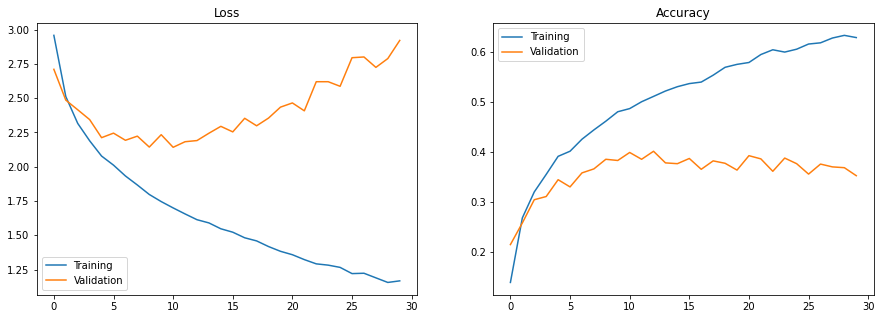

Estadísticas de BaseNet (simple)
 - Test loss: 2.74863862991333
 - Test accuracy: 0.4032000005245209


In [ ]:
_m[0] = BaseNet()
_h[0], _s[0] = train(_m[0], *_cargar_dataset('cifar100'), get_datagenerator('simple', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[0])
_print_evaluate(_m[0], _s[0], 'simple')

Comentaremos las gráficas obtenidas. Vemos que a partir de alrededor de las 10 épocas, comienza a subir el error de validación (_loss_), mientras que la precisión en validación se estabiliza en $(0.3, 0.4)$, llegando a disminuir al llegar a las últimas épocas. Dado que la pérdida y la precisión son muchos mejores en el entrenamiento, vemos que nuestro modelo está entrando en _overfitting_. Veamos cómo podemos mejorar este modelo en el apartado siguiente.

- - -

### Apartado 2. **Mejora del modelo BaseNet**

Ahora el objetivo es crear, haciendo elecciones juiciosas de arquitectura e
implementación, una red profunda mejorada partiendo de BaseNet. Una buena
combinación de capas puede hacer que la precisión del nuevo modelo se
acerque al 50% sobre nuestros datos de CIFAR-100. Para mejorar la red, puede
considerar añadir cualquier combinación de entre las siguientes opciones de
mejora:

1. **Normalización de datos.** La normalización a escala de los datos de entrada,
en general, hace que el entrenamiento sea más fácil y más sólido. Utilice la clase
`ImageDataGenerator` con los parámetros correctos para que los datos estén bien
condicionados (media=0, stddev=1) para mejorar el entrenamiento. Debe
garantizar que `test_transform` use los mismos parámetros de normalización que
`train_transform`. Ver la capa de `Normalization`.
2. **Aumento de datos.** Intente usar algunos de los parámetros de aumento de
datos de la clase `ImageDataGenerator`, como `zoom_range` y /o `horizontal_flip`.
No debería tener ningún aumento de datos en los conjuntos de validación ni 
test. Si necesita una mejor comprensión, intente leer el tutorial de Keras sobre
transformaciones. Ver las capas de _image processing and augmentation_.
3. **Aumento de profundidad.** Experimente agregando capas convolucionales. No
coloque siempre una capa de maxpool después de cada capa conv, ya que
conduce a una pérdida excesiva de información por reducción del número de
unidades. Si lo necesita use capas de UpSampling (Transposed Convolution)
para aumentar el número de unidades.
4. ***Batch normalization.*** Las capas de batch normalization en la mayoría de los
casos ayudan a reducir el sobreajuste y mejorar el entrenamiento del modelo.
Las capas de Batch Normalization de Keras son una forma fácil de incorporarlas
al modelo. Agregue capas de normalización después de capas lineales (conv) y
antes de la capa ReLU, pero experimente también con después de las capas
ReLU.
5. ***Dropout.*** Esta capa introduce regularización seleccionando de forma
aleatoria un porcentaje de neuronas activas para cada mini-batch. Esto ayuda a
que la red especialice las neuronas en informaciones especificas e
independientes.
6. ***Early stopping.*** ¿Después de cuántas épocas parar y dejar de entrenar? La
[discusión en Stack Exchange](https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set/18346#18346)
es un buen resumen del uso de divisiones train-valtest para reducir el sobreajuste.
Este [blog](https://elitedatascience.com/overfitting-in-machine-learning#how-to-prevent) también es una buena referencia para
“early stopping”. Recuerde, nunca debe usar el conjunto de test en otra cosa que
no sea la evaluación final. Mirando las gráficas de pérdida de entrenamiento y
precisión en validación, decida cuántas épocas entrenará su modelo (evalue
para ello los mínimos y máximos y locales de las gráficas de perdida y
precisión, respectivamente). No fije demasiadas (ya que eso conduce a un
sobreajuste) y tampoco muy pocas (de lo contrario, su modelo no habrá
aprendido lo suficiente). Keras proporciona un criterio parametrizado para fijar
sus decisiones.

Recuerde que en su informe, deberá incluir una tabla similar a la mostrada en
el punto 1 para ilustrar la arquitectura de su red final. Además, deberá explicar
los pasos dados con los resultados parciales obtenidos que finalmente le han
llevado a introducir las modificaciones propuestas.

##### Solución propuesta

Vamos a modificar el modelo anterior para obtener una mejor clasificación, y evitar el _overfitting_. Propondremos una serie de mejoras que discutiremos y compraremos.

#### Normalización de datos

Primero, pretendremos que nuestros datos se distribuyan con media nula y varianza unidad, $\mu=0, \sigma^2=1$. Para ello, basta usar un _data generator_ con los siguientes parámetros:

* `featurewise_center=True`. Consigue que los datos tengan $\mu=0$.
* `featurewise_std_normalization=True`. Consigue que los datos tengan $\sigma^2=1$.

Para usar este generador, basta llamar a la función `get_datagenerator` con el parámetro `name='normalize'` (incluye además el parámetro `validation_split`).

> En la función `get_datagenerator`, definida anteriormente, aparecen todas las definiciones de los generadores. En este apartado explicaremos los parámetros uno a uno.

Epoch 1/30
351/351 [==============================] - 4s 9ms/step - loss: 2.7156 - acc: 0.2044 - val_loss: 2.4711 - val_acc: 0.2800
Epoch 2/30
351/351 [==============================] - 3s 8ms/step - loss: 2.3191 - acc: 0.3215 - val_loss: 2.4278 - val_acc: 0.3024
Epoch 3/30
351/351 [==============================] - 3s 8ms/step - loss: 2.1303 - acc: 0.3732 - val_loss: 2.2240 - val_acc: 0.3440
Epoch 4/30
351/351 [==============================] - 3s 9ms/step - loss: 2.0241 - acc: 0.4004 - val_loss: 2.2146 - val_acc: 0.3464
Epoch 5/30
351/351 [==============================] - 3s 9ms/step - loss: 1.9443 - acc: 0.4257 - val_loss: 2.2326 - val_acc: 0.3424
Epoch 6/30
351/351 [==============================] - 3s 9ms/step - loss: 1.8488 - acc: 0.4455 - val_loss: 2.2335 - val_acc: 0.3856
Epoch 7/30
351/351 [==============================] - 3s 9ms/step - loss: 1.8032 - acc: 0.4642 - val_loss: 2.2890 - val_acc: 0.3464
Epoch 8/30
351/351 [==============================] - 3s 9ms/step - loss: 1.

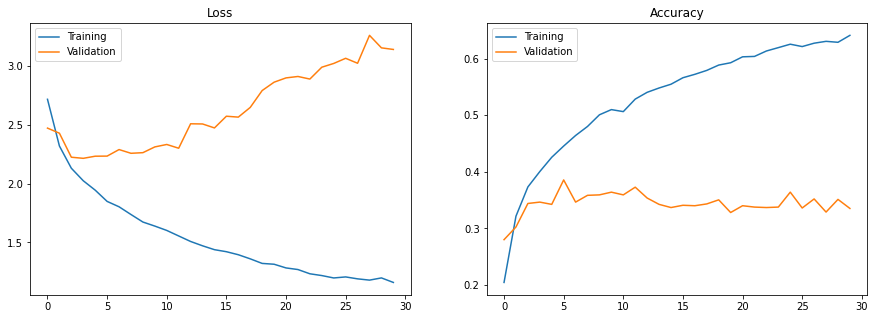

Estadísticas de BaseNet (normalize)
 - Test loss: 3.1726067066192627
 - Test accuracy: 0.35519999265670776


In [ ]:
_m[1] = BaseNet()
_h[1], _s[1] = train(_m[1], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[1])
_print_evaluate(_m[1], _s[1], 'normalize')

Vemos que no se produce una mejora. En las diversas iteraciones ha habido ocasiones en la que ha habido una leve mejora o un leve empeoramiento -- recordemos que el proceso de entrenamiento tiene un componente aleatorio. Sin embargo, es conveniente tener los datos normalizados, por lo que de aquí en adelante seguiremos usando la normalización.

#### Aumento de datos

Para mejorar el entrenamiento de nuestra red podemos usar _data augmentation_, que modifica las imágenes de entrenamiento para aportar más información a nuestro modelo. La idea es sustituir aleatoriamente algunas imágenes de entrenamiento por otras con ciertas perturbaciones/transformaciones aleatorias. Estas transformaciones las conseguimos mediante los siguientes parámetros del _generator_:

* `width_shift_range=.1`. Realiza movimientos horizontales tomando el valor como el porcentaje del ancho total como rango (explicación al detalle [aquí](https://stackoverflow.com/questions/62484597/understanding-width-shift-range-and-height-shift-range-arguments-in-kerass)).
* `height_shift_range=.1`. Ídem `width_shift_range` con movimientos verticales.
* `zoom_range=.2`. Hacemos un aumento aleatorio con factor en el intervalo $[1-0.2, 1+0.2]$.
* `horizontal_flip=True`. Volteamos la imagen horizontalmente.

Para usar este generador, basta llamar a la función `get_datagenerator` con el parámetro `name='augment_normalize'` (incluye parámetros de normalización y validación).

Epoch 1/30
351/351 [==============================] - 20s 56ms/step - loss: 2.7837 - acc: 0.1891 - val_loss: 2.5651 - val_acc: 0.2248
Epoch 2/30
351/351 [==============================] - 11s 32ms/step - loss: 2.4750 - acc: 0.2775 - val_loss: 2.5203 - val_acc: 0.2448
Epoch 3/30
351/351 [==============================] - 11s 32ms/step - loss: 2.3723 - acc: 0.3014 - val_loss: 2.4103 - val_acc: 0.2936
Epoch 4/30
351/351 [==============================] - 11s 32ms/step - loss: 2.2956 - acc: 0.3241 - val_loss: 2.4143 - val_acc: 0.2752
Epoch 5/30
351/351 [==============================] - 11s 32ms/step - loss: 2.2467 - acc: 0.3388 - val_loss: 2.2937 - val_acc: 0.3192
Epoch 6/30
351/351 [==============================] - 11s 32ms/step - loss: 2.2025 - acc: 0.3527 - val_loss: 2.2668 - val_acc: 0.3424
Epoch 7/30
351/351 [==============================] - 11s 32ms/step - loss: 2.1574 - acc: 0.3708 - val_loss: 2.2687 - val_acc: 0.3272
Epoch 8/30
351/351 [==============================] - 11s 32ms

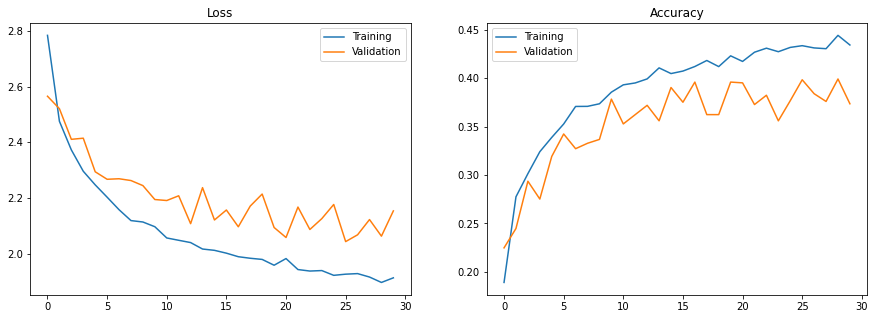

Estadísticas de BaseNet (augment_normalize)
 - Test loss: 1.8932374715805054
 - Test accuracy: 0.44519999623298645


In [ ]:
_m[2] = BaseNet()
_h[2], _s[2] = train(_m[2], *_cargar_dataset('cifar100'), get_datagenerator('augment_normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[2])
_print_evaluate(_m[2], _s[2], 'augment_normalize')

Primero, notemos cómo los tiempos de ejecución de cada época han aumentado notablemente, como era esperable, dado que debemos de realizar transformaciones a cada imagen. Por otra parte, hemos obtenido una considerable mejora en el _accuracy_, pero lo que es más importante: las pérdidas y _accuracies_ de validación cada vez están más cercanas de las de entrenamiento. Esto nos indica que nuestro modelo generaliza mejor, de hecho es el mejor que hemos analizado hasta ahora.

Podemos probar otros tipos de aumento de datos para ver si aportan significativamente a la mejora del modelo. Probaremos una variación, que llamamos `'augment_normalize_2'`, en el que añadimos rotaciones y cortes, en concreto añadimos los parámetros:

* `rotation_range=60`, que permite que las imágenes puedan rotarse en un ángulo de hasta 60º.
* `shear_range=0.15`, que permite cortes en las imágenes.

Epoch 1/30
351/351 [==============================] - 16s 41ms/step - loss: 2.9082 - acc: 0.1494 - val_loss: 2.7367 - val_acc: 0.2088
Epoch 2/30
351/351 [==============================] - 12s 34ms/step - loss: 2.6313 - acc: 0.2296 - val_loss: 2.6337 - val_acc: 0.2192
Epoch 3/30
351/351 [==============================] - 12s 34ms/step - loss: 2.5243 - acc: 0.2612 - val_loss: 2.5815 - val_acc: 0.2440
Epoch 4/30
351/351 [==============================] - 12s 34ms/step - loss: 2.4524 - acc: 0.2730 - val_loss: 2.4936 - val_acc: 0.2536
Epoch 5/30
351/351 [==============================] - 12s 34ms/step - loss: 2.4047 - acc: 0.2868 - val_loss: 2.4463 - val_acc: 0.2760
Epoch 6/30
351/351 [==============================] - 15s 42ms/step - loss: 2.3762 - acc: 0.2971 - val_loss: 2.4975 - val_acc: 0.2424
Epoch 7/30
351/351 [==============================] - 12s 34ms/step - loss: 2.3530 - acc: 0.3040 - val_loss: 2.4424 - val_acc: 0.2824
Epoch 8/30
351/351 [==============================] - 12s 33ms

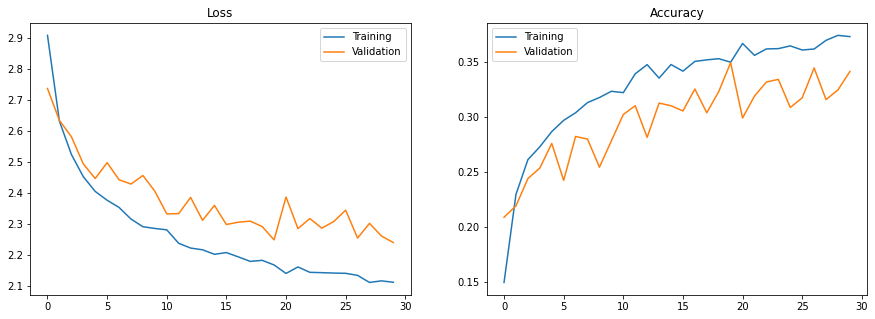

Estadísticas de BaseNet (augment_normalize_2)
 - Test loss: 2.003049373626709
 - Test accuracy: 0.3935999870300293


In [ ]:
_m[3] = BaseNet()
_h[3], _s[3] = train(_m[3], *_cargar_dataset('cifar100'), get_datagenerator('augment_normalize_2', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[3])
_print_evaluate(_m[3], _s[3], 'augment_normalize_2')

Al tener más transformaciones posibles, los tiempos de ejecución también han aumentado. Sin embargo, el _accuracy_ en _test_ no ha mejorado. Esto nos indica que añadir transformaciones no tiene por qué necesariamente mejorar el modelo.

Como conclusión en este apartado, vemos que el aumento de datos es bastante positivo para los modelos de CNN, pero que no debemos caer en incorporar todas las transformaciones posibles.

#### Aumento de profundidad

Probaremos ahora a añadir más capas a nuestro modelo inicial, para ello crearemos un `CNNModel` nuevo, que llamaremos `BaseNetDeeper`.

Mantendremos el tamaño de las imágenes en la primera convolución de cada conjunto de convoluciones consecutivas mediante `padding='same'`. De este modo, no perdemos la dimensión rápidamente. Del mismo modo, vamos a reducir el tamaño de los _kernels_ cuando tengamos convoluciones consecutivas.

No vamos a usar _data augmentation_ para este apartado, para poder comparar individualmente el efecto de cada estrategia. Simplemente volveremos a usar el generador `'normalize'` para trabajar con los datos normalizados.

In [ ]:
class BaseNetDeeper(CNNModel):
    """ Modelo BaseNet (más profundo)
    """
    def __init__(self):
        self.model = Sequential()
        # layers 1 (MODIFICAMOS el número de filtros de 6 a 32 y el tamaño del kernel), 2
        self.model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
        # AÑADIMOS una nueva convolución con más canales
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
        # layer 3
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # layers 4, 5
        self.model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
        # AÑADIMOS una nueva convolución con más canales
        self.model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
        # layer 6
        self.model.add(MaxPooling2D(pool_size=(3, 3)))
        # aplanar antes de una FC
        self.model.add(Flatten())
        # AÑADIMOS una capa densa de mayor tamaño
        self.model.add(Dense(100, activation='relu'))
        # layers 7, 8
        self.model.add(Dense(50, activation='relu'))
        # layer 9, softmax
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNetDeeper'

Epoch 1/30
351/351 [==============================] - 5s 13ms/step - loss: 2.8472 - acc: 0.1624 - val_loss: 2.5437 - val_acc: 0.2192
Epoch 2/30
351/351 [==============================] - 4s 12ms/step - loss: 2.4312 - acc: 0.2831 - val_loss: 2.4310 - val_acc: 0.2752
Epoch 3/30
351/351 [==============================] - 4s 12ms/step - loss: 2.2408 - acc: 0.3372 - val_loss: 2.3323 - val_acc: 0.3080
Epoch 4/30
351/351 [==============================] - 4s 12ms/step - loss: 2.1071 - acc: 0.3798 - val_loss: 2.2698 - val_acc: 0.3304
Epoch 5/30
351/351 [==============================] - 4s 12ms/step - loss: 1.9731 - acc: 0.4208 - val_loss: 2.1416 - val_acc: 0.3728
Epoch 6/30
351/351 [==============================] - 4s 12ms/step - loss: 1.8838 - acc: 0.4452 - val_loss: 2.1404 - val_acc: 0.3720
Epoch 7/30
351/351 [==============================] - 4s 12ms/step - loss: 1.7919 - acc: 0.4624 - val_loss: 2.0910 - val_acc: 0.4008
Epoch 8/30
351/351 [==============================] - 4s 12ms/step - 

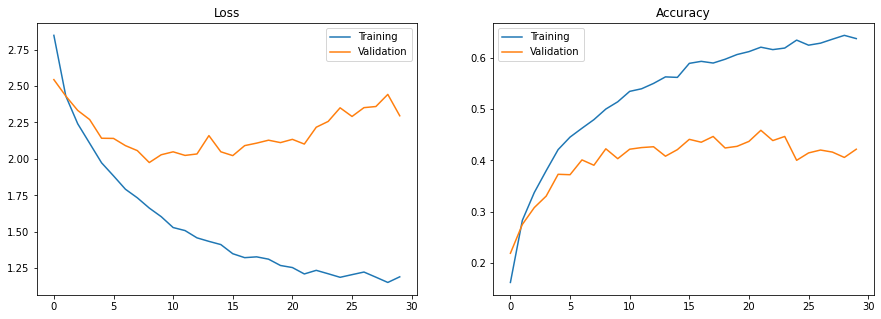

Estadísticas de BaseNetDeeper (normalize)
 - Test loss: 2.1768033504486084
 - Test accuracy: 0.4708000123500824


In [ ]:
_m[4] = BaseNetDeeper()
_h[4], _s[4] = train(_m[4], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[4])
_print_evaluate(_m[4], _s[4], 'normalize')

Vemos cómo obtenemos un mejor _accuracy_ en _test_, pues nuestra nueva CNN es capaz de extraer características de una forma más fina. Sin embargo, caemos de nuevo en _overfitting_. Para que esto no ocurra, debemos combinar el aumento de profunidad con otras estrategias, como el resto de las que estamos analizando.

Adicionalmente, el modelo `BaseNetDeeper` tiene un número de parámetros entrenables considerablemente mayor al de `BaseNet`, como podemos ver a continuación:

In [ ]:
print("Resumen de BaseNet")
print("------------------")
_m[0].model.summary()

Resumen de BaseNet
------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)    

In [ ]:
print("Resumen de BaseNetDeeper")
print("------------------------")
_m[4].model.summary()

Resumen de BaseNetDeeper
------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 15, 15, 16)        4624      
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 16)        6416      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 3, 3, 16)         0         
 2D)

#### _Batch normalization_

Vamos a añadir a nuestro modelo _batch normalization_, que aumenta el rendimiento y estabilidad de nuestra CNN. Esta técnica consiste en normalizar _batches_ para intentar mantener la salida en cada capa con una media cercana a 0 y una desviación típica cercana a 1. Las capas de _batch normalization_ tipifican los datos de cada _batch_ y después realizan la transformación lineal: $$y_i^{(k)}=\gamma^{(k)}\hat{x_i}^{(k)}+\beta^{(k)}$$
Donde $(k)$ denota la $k$-ésima componente, $x_i$ el $i$-ésimo dato del batch, $\hat{x_i}$ denota tal dato tipificado (con media 0 y desviación 1), y $\gamma$ y $\beta$ se aprenden en el entrenamiento.

Vamos a probar tres alternativas para implementar el _batch normalization_:
* Antes de la activación: `BaseNetBNPre`.
* Después de la activación: `BaseNetBNPos`.

Creamos los `CCNModel` para cada alternativa a continuación.

In [ ]:
class BaseNetBNPre(CNNModel):
    """ Modelo BaseNetBNPre
    """
    def __init__(self):
        self.model = Sequential()
        # layer 1
        self.model.add(Conv2D(6, kernel_size=(5, 5), use_bias=False, input_shape=(32, 32, 3)))
        # AÑADIMOS BatchNormalization antes de ReLU
        self.model.add(BatchNormalization())
        # layer 2
        self.model.add(Activation('relu'))
        # layer 3
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # layer 4
        self.model.add(Conv2D(16, kernel_size=(5, 5), use_bias=False))
        # AÑADIMOS BatchNormalization antes de ReLU
        self.model.add(BatchNormalization())
        # layer 5
        self.model.add(Activation('relu'))
        # layer 6
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # aplanar antes de una FC
        self.model.add(Flatten())
        # layer 7
        self.model.add(Dense(50, use_bias=False))
        # AÑADIMOS BatchNormalization antes de ReLU
        self.model.add(BatchNormalization())
        # layer 8
        self.model.add(Activation('relu'))
        # layer 9, softmax
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNetBNPre'

class BaseNetBNPos(CNNModel):
    """ Modelo BaseNetBNPos
    """
    def __init__(self):
        self.model = Sequential()
        # layers 1, 2
        self.model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
        # AÑADIMOS BatchNormalization después de ReLU
        self.model.add(BatchNormalization())
        # layer 3
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # layers 4, 5
        self.model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
        # AÑADIMOS BatchNormalization después de ReLU
        self.model.add(BatchNormalization())
        # layer 6
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # aplanar antes de una FC
        self.model.add(Flatten())
        # layers 7, 8
        self.model.add(Dense(50, activation='relu'))
        # AÑADIMOS BatchNormalization después de ReLU
        self.model.add(BatchNormalization())
        # layer 9, softmax
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNetBNPos'

Y los usamos para entrenar con el _data generator_ `'normalize'`, como hemos hecho hasta ahora.

Epoch 1/30
351/351 [==============================] - 4s 10ms/step - loss: 2.6155 - acc: 0.2444 - val_loss: 2.3589 - val_acc: 0.3080
Epoch 2/30
351/351 [==============================] - 4s 11ms/step - loss: 2.1855 - acc: 0.3636 - val_loss: 2.1645 - val_acc: 0.3736
Epoch 3/30
351/351 [==============================] - 3s 9ms/step - loss: 1.9737 - acc: 0.4164 - val_loss: 2.0746 - val_acc: 0.3936
Epoch 4/30
351/351 [==============================] - 3s 10ms/step - loss: 1.8079 - acc: 0.4640 - val_loss: 1.9167 - val_acc: 0.4256
Epoch 5/30
351/351 [==============================] - 3s 9ms/step - loss: 1.7287 - acc: 0.4837 - val_loss: 1.9436 - val_acc: 0.4232
Epoch 6/30
351/351 [==============================] - 3s 9ms/step - loss: 1.6416 - acc: 0.5069 - val_loss: 1.9170 - val_acc: 0.4160
Epoch 7/30
351/351 [==============================] - 4s 10ms/step - loss: 1.5624 - acc: 0.5356 - val_loss: 2.0436 - val_acc: 0.4248
Epoch 8/30
351/351 [==============================] - 3s 9ms/step - loss

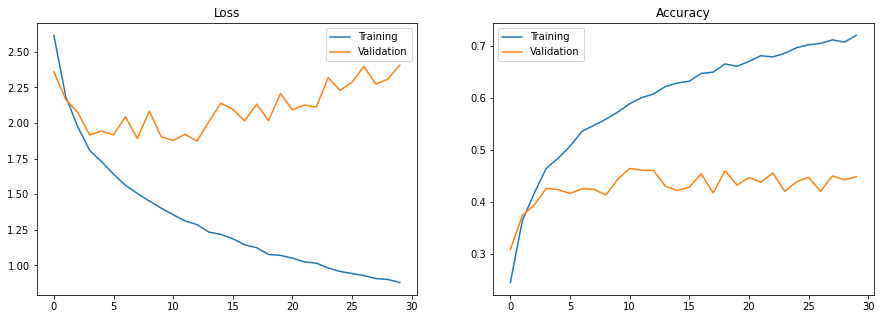

Estadísticas de BaseNetBNPre (normalize)
 - Test loss: 2.325643539428711
 - Test accuracy: 0.4447999894618988


In [ ]:
_m[5] = BaseNetBNPre()
_h[5], _s[5] = train(_m[5], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[5])
_print_evaluate(_m[5], _s[5], 'normalize')

In [ ]:
print("Resumen de BaseNetNPre")
print("----------------------")
_m[5].model.summary()

Resumen de BaseNetNPre
----------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 6)         450       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 16)        2400      
                                                                 
 batch_n

Epoch 1/30
351/351 [==============================] - 5s 12ms/step - loss: 2.6116 - acc: 0.2458 - val_loss: 2.3353 - val_acc: 0.3184
Epoch 2/30
351/351 [==============================] - 3s 10ms/step - loss: 2.1529 - acc: 0.3716 - val_loss: 2.1351 - val_acc: 0.3776
Epoch 3/30
351/351 [==============================] - 3s 9ms/step - loss: 1.9567 - acc: 0.4252 - val_loss: 2.0432 - val_acc: 0.3976
Epoch 4/30
351/351 [==============================] - 3s 9ms/step - loss: 1.8190 - acc: 0.4559 - val_loss: 1.9526 - val_acc: 0.4176
Epoch 5/30
351/351 [==============================] - 3s 10ms/step - loss: 1.7140 - acc: 0.4853 - val_loss: 1.9801 - val_acc: 0.4184
Epoch 6/30
351/351 [==============================] - 5s 14ms/step - loss: 1.6317 - acc: 0.5074 - val_loss: 1.8800 - val_acc: 0.4448
Epoch 7/30
351/351 [==============================] - 5s 13ms/step - loss: 1.5819 - acc: 0.5260 - val_loss: 1.8406 - val_acc: 0.4512
Epoch 8/30
351/351 [==============================] - 5s 14ms/step - lo

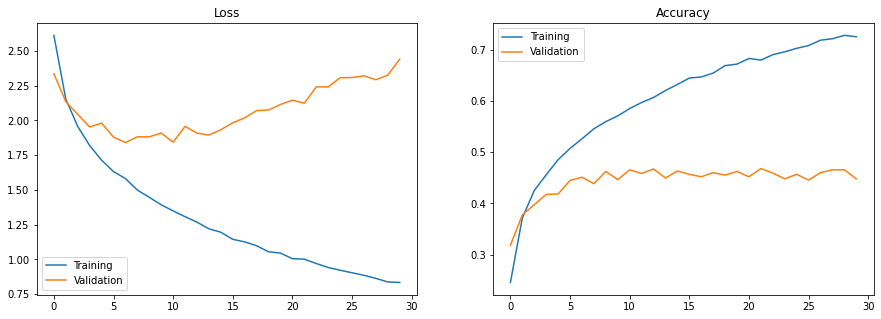

Estadísticas de BaseNetBNPos (normalize)
 - Test loss: 2.416644811630249
 - Test accuracy: 0.45159998536109924


In [ ]:
_m[6] = BaseNetBNPos()
_h[6], _s[6] = train(_m[6], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[6])
_print_evaluate(_m[6], _s[6], 'normalize')

In [ ]:
print("Resumen de BaseNetNPos")
print("----------------------")
_m[6].model.summary()

Resumen de BaseNetNPos
----------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 6)        24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_4 (Batc  (None, 10, 10, 16)       64        
 hNormalization)                                                 
        

Dado que es complicado ver las diferencias entre ambas, vamos a ver las evoluciones de ambos en la misma gráfica.

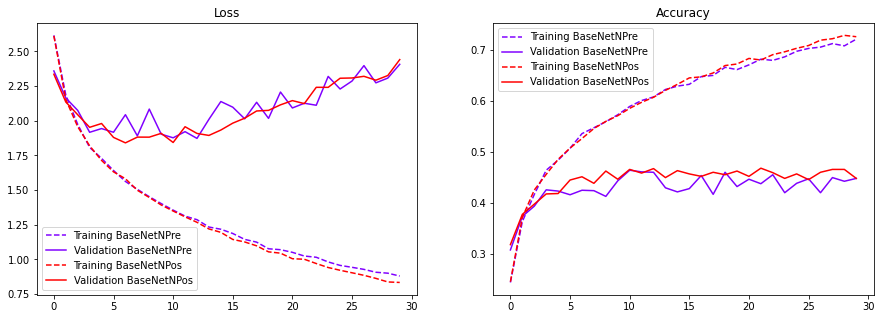

In [ ]:
_mostrar_evoluciones({'BaseNetNPre': _h[5], 'BaseNetNPos': _h[6]})

Podemos ver que, aunque el resultado sea muy similar en ambos modelos, vemos que el _accuracy_ es siempre mayor en todas las épocas para `BaseNetNPos`, mientras que el _loss_ es casi siempre inferior.

Por tanto, vemos que aunque la diferencia sea poco significativa, obtenemos siempre mayor _accuracy_ cuando realizamos _batch normalization_ **después** de la función de activación. De cara al modelo mejorado (`BaseNetImproved`), usaremos _batch normalization_ siempre después de ReLU.

#### _Dropout_

La penúltima mejora que probaremos será el _dropout_. En el _drouput_, simplemente hacemos que las neuronas de nuestro modelo no sean entrenadas en cada entrenamiento, con una cierta probabilidad.

Para implementar esta mejora, basta añadir una capa `Dropout` al modelo. Realizaremos _dropout_ tanto después de los _max pooling_ como después de la penúltima capa `Dense`.

Implementaremos además dos variaciones de _dropout_: una `BaseNetDropout` y otra `BaseNetDropoutLower` en las que las probabilidades son menores (en concreto, la mitad que en `BaseNetDropout`).

In [ ]:
class BaseNetDropout(CNNModel):
    """ Modelo BaseNetDropout
    """
    def __init__(self):
        self.model = Sequential()
        # layers 1, 2
        self.model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
        # layer 3
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # AÑADIMOS dropout
        self.model.add(Dropout(0.25))
        # layers 4, 5
        self.model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
        # layer 6
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # AÑADIMOS dropout
        self.model.add(Dropout(0.25))
        # aplanar antes de una FC
        self.model.add(Flatten())
        # layers 7, 8
        self.model.add(Dense(50, activation='relu'))
        # AÑADIMOS dropout
        self.model.add(Dropout(0.5))
        # layer 9, softmax
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNetDropout'

class BaseNetDropoutLower(CNNModel):
    """ Modelo BaseNetDropout
    """
    def __init__(self):
        self.model = Sequential()
        # layers 1, 2
        self.model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
        # layer 3
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # AÑADIMOS dropout
        self.model.add(Dropout(0.1))
        # layers 4, 5
        self.model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
        # layer 6
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        # AÑADIMOS dropout
        self.model.add(Dropout(0.1))
        # aplanar antes de una FC
        self.model.add(Flatten())
        # layers 7, 8
        self.model.add(Dense(50, activation='relu'))
        # AÑADIMOS dropout
        self.model.add(Dropout(0.2))
        # layer 9, softmax
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNetDropoutLower'

Epoch 1/30
351/351 [==============================] - 4s 9ms/step - loss: 3.1277 - acc: 0.0862 - val_loss: 3.0731 - val_acc: 0.1256
Epoch 2/30
351/351 [==============================] - 3s 10ms/step - loss: 2.9071 - acc: 0.1577 - val_loss: 2.8627 - val_acc: 0.1928
Epoch 3/30
351/351 [==============================] - 3s 9ms/step - loss: 2.7919 - acc: 0.1784 - val_loss: 2.6485 - val_acc: 0.2192
Epoch 4/30
351/351 [==============================] - 3s 9ms/step - loss: 2.7460 - acc: 0.1881 - val_loss: 2.7200 - val_acc: 0.2072
Epoch 5/30
351/351 [==============================] - 4s 11ms/step - loss: 2.6960 - acc: 0.2041 - val_loss: 2.5504 - val_acc: 0.2368
Epoch 6/30
351/351 [==============================] - 5s 13ms/step - loss: 2.6646 - acc: 0.2081 - val_loss: 2.5435 - val_acc: 0.2288
Epoch 7/30
351/351 [==============================] - 5s 15ms/step - loss: 2.6530 - acc: 0.2108 - val_loss: 2.4965 - val_acc: 0.2440
Epoch 8/30
351/351 [==============================] - 6s 16ms/step - los

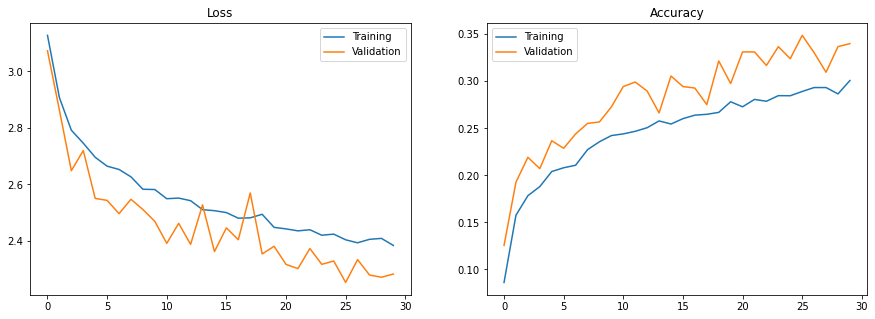

Estadísticas de BaseNetDropout (normalize)
 - Test loss: 2.202151298522949
 - Test accuracy: 0.3675999939441681


In [ ]:
_m[7] = BaseNetDropout()
_h[7], _s[7] = train(_m[7], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[7])
_print_evaluate(_m[7], _s[7], 'normalize')

Epoch 1/30
351/351 [==============================] - 4s 9ms/step - loss: 2.8775 - acc: 0.1595 - val_loss: 2.5346 - val_acc: 0.2464
Epoch 2/30
351/351 [==============================] - 3s 8ms/step - loss: 2.5532 - acc: 0.2540 - val_loss: 2.6239 - val_acc: 0.2232
Epoch 3/30
351/351 [==============================] - 3s 9ms/step - loss: 2.4165 - acc: 0.2877 - val_loss: 2.3696 - val_acc: 0.3112
Epoch 4/30
351/351 [==============================] - 4s 11ms/step - loss: 2.3146 - acc: 0.3218 - val_loss: 2.2276 - val_acc: 0.3456
Epoch 5/30
351/351 [==============================] - 4s 12ms/step - loss: 2.2499 - acc: 0.3371 - val_loss: 2.2529 - val_acc: 0.3144
Epoch 6/30
351/351 [==============================] - 4s 11ms/step - loss: 2.1980 - acc: 0.3472 - val_loss: 2.1911 - val_acc: 0.3496
Epoch 7/30
351/351 [==============================] - 3s 10ms/step - loss: 2.1738 - acc: 0.3552 - val_loss: 2.2025 - val_acc: 0.3472
Epoch 8/30
351/351 [==============================] - 5s 13ms/step - los

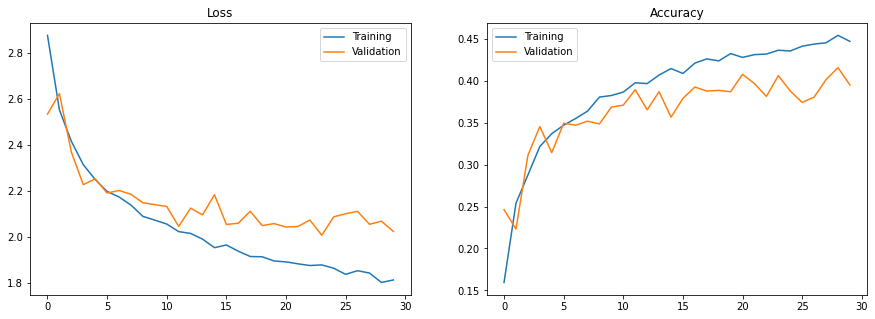

Estadísticas de BaseNetDropoutLower (normalize)
 - Test loss: 1.980149745941162
 - Test accuracy: 0.4307999908924103


In [ ]:
_m[8] = BaseNetDropoutLower()
_h[8], _s[8] = train(_m[8], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[8])
_print_evaluate(_m[8], _s[8], 'normalize')

Comparemos de nuevo ambas opciones, y también lo comparemos con el modelo original (únicamente haciendo _normalize_).

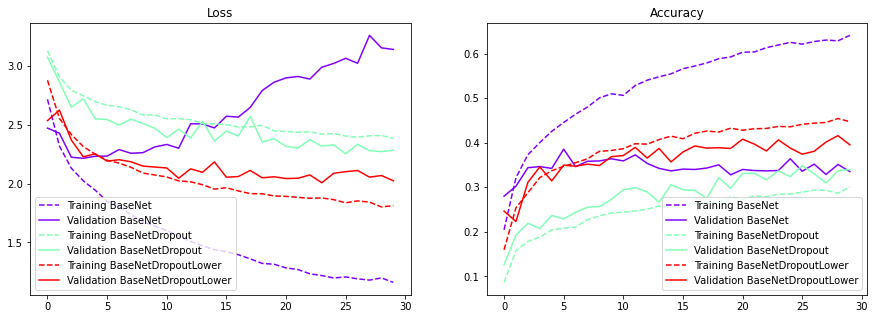

In [ ]:
_mostrar_evoluciones({'BaseNet': _h[1], 'BaseNetDropout': _h[7], 'BaseNetDropoutLower': _h[8]})

Vemos cómo, claramente, es mejor hacer _dropout_, pues obtenemos una mejor generalización. También vemos cómo la elección de las probabilidades varía considerablemente la posibildiad de aprender de nuestro modelo: en nuestro caso, `BaseNetDropoutLower` obtiene mejores resultados (mayor _accuracy_ y menor _loss_).

En general, la elección de las probabilidades del _dropout_ no es una tarea sencilla: si es muy baja, tendremos un modelo prácticamente sin _dropout_. Si es muy alta, no lograremos aprender mucho. En nuestro caso, si el ratio de _dropout_ fuese aún menor que `BaseNetDropoutLower`, nos acercaríamos a los resultados de `BaseNet`, que son incluso peores que los de `BaseNetDropout`.

#### _Early stopping_

Implementaremos el _early stopping_ en todas las opciones que vamos a considerar. La idea es parar el entrenamiento si el modelo no consigue mejorar tras pasar una serie de épocas. De este modo, conseguiremos que los tiempos de ejecución no se alarguen innecesariamente.

Esta funcionalidad ya fue implementada en la función `train`: basta especificar el parámetro `early_stopping=True` (por defecto es `early_stopping=False`). Primero, algunos detalles de implementación:
* El _early stopping_ ha sido implementado mediante un **callback**. En Keras, un callback es un conjunto de funciones que se aplicarán en ciertos momentos del entrenamiento.
* Los callbacks se añaden a la lista `callback`, que se pasa como parámetro a la función `fit`.
* Añadimos dos callbacks: uno para considerar la mejora en _loss_ y otro en _accuracy_.
* La función `keras.callbacks.EarlyStopping` tiene dos parámetros que usamos:
  * `monitor`: es el parámetro que queremos ver si está cambiando.
  * `patience`: número de épocas a esperar sin que se modifique para parar el entrenamiento. Le pasamos el valor del parámetro `patience`, que por defecto es `patience=5`.

Hemos especificado por defecto `patience=5` dado que el número de épocas es relativamente bajo (estamos en torno a 30).

Para ver el efecto del _early stopping_, lo ejecutaremos sobre el modelo del apartado A.

Epoch 1/30
351/351 [==============================] - 4s 10ms/step - loss: 2.7929 - acc: 0.1934 - val_loss: 2.5348 - val_acc: 0.2448
Epoch 2/30
351/351 [==============================] - 4s 12ms/step - loss: 2.3873 - acc: 0.3042 - val_loss: 2.3599 - val_acc: 0.2976
Epoch 3/30
351/351 [==============================] - 4s 12ms/step - loss: 2.2077 - acc: 0.3478 - val_loss: 2.3232 - val_acc: 0.3240
Epoch 4/30
351/351 [==============================] - 4s 10ms/step - loss: 2.0881 - acc: 0.3852 - val_loss: 2.3098 - val_acc: 0.3392
Epoch 5/30
351/351 [==============================] - 3s 9ms/step - loss: 1.9914 - acc: 0.4103 - val_loss: 2.2566 - val_acc: 0.3480
Epoch 6/30
351/351 [==============================] - 3s 9ms/step - loss: 1.9089 - acc: 0.4309 - val_loss: 2.2837 - val_acc: 0.3536
Epoch 7/30
351/351 [==============================] - 3s 8ms/step - loss: 1.8461 - acc: 0.4484 - val_loss: 2.1860 - val_acc: 0.3736
Epoch 8/30
351/351 [==============================] - 3s 8ms/step - loss

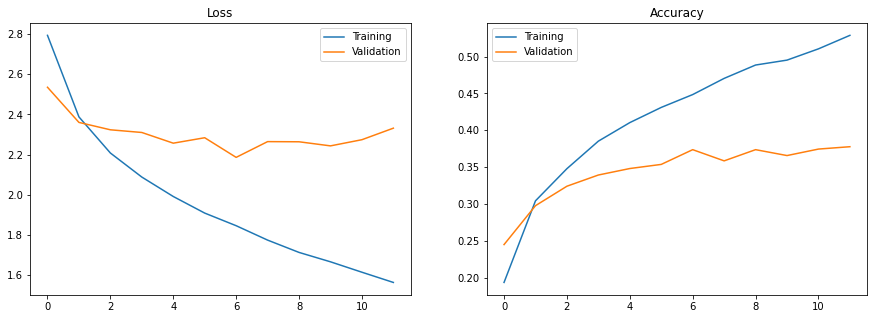

Estadísticas de BaseNet (normalize w/ early stopping)
 - Test loss: 2.1046910285949707
 - Test accuracy: 0.39160001277923584


In [ ]:
_m[9] = BaseNet()
_h[9], _s[9] = train(_m[9], *_cargar_dataset('cifar100'), get_datagenerator('normalize', validation_split=.1), batch_size=32, n_epochs=30, early_stopping=True)
_mostrar_evolucion(_h[9])
_print_evaluate(_m[9], _s[9], 'normalize w/ early stopping')

Con los parámetros espeificados, hemos obtenido un _early stop_ en la época 12. Vemos cómo _early stopping_ consigue parar el entrenamiento cuando vemos que ya no hay mucho más que aprender. En concreto, el modelo ha parado porque ha visto que el _accuracy_ no cambiaba considerablemente. En efecto, en la época 30 del modelo sin _early stopping_ vemos que no obtenemos mejoras significativas.

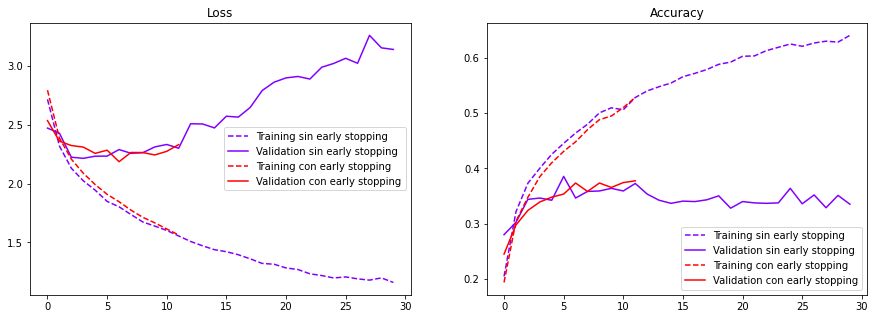

In [ ]:
_mostrar_evoluciones({'sin early stopping': _h[1], 'con early stopping': _h[9]})

#### Modelo mejorado

Vamos a implementar todo el conocimiento ya desarrollado de las mejoras para crear un modelo mejorado, `BaseNetImproved`.

In [ ]:
class BaseNetImproved(CNNModel):
    """ Modelo BaseNetImproved
    """
    def __init__(self):
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.1))
        self.model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.1))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.2))
        self.model.add(Dense(25, activation='softmax'))

        self.name = 'BaseNetImproved'

Epoch 1/30
351/351 [==============================] - 15s 39ms/step - loss: 2.7859 - acc: 0.2359 - val_loss: 2.3846 - val_acc: 0.3224
Epoch 2/30
351/351 [==============================] - 13s 38ms/step - loss: 2.3098 - acc: 0.3363 - val_loss: 2.2064 - val_acc: 0.3472
Epoch 3/30
351/351 [==============================] - 13s 37ms/step - loss: 2.0705 - acc: 0.3933 - val_loss: 2.0235 - val_acc: 0.3976
Epoch 4/30
351/351 [==============================] - 14s 39ms/step - loss: 1.9117 - acc: 0.4387 - val_loss: 1.8740 - val_acc: 0.4456
Epoch 5/30
351/351 [==============================] - 13s 38ms/step - loss: 1.7767 - acc: 0.4738 - val_loss: 1.7574 - val_acc: 0.4768
Epoch 6/30
351/351 [==============================] - 13s 38ms/step - loss: 1.6593 - acc: 0.5025 - val_loss: 1.7049 - val_acc: 0.4960
Epoch 7/30
351/351 [==============================] - 14s 38ms/step - loss: 1.5499 - acc: 0.5269 - val_loss: 1.5518 - val_acc: 0.5296
Epoch 8/30
351/351 [==============================] - 14s 40ms

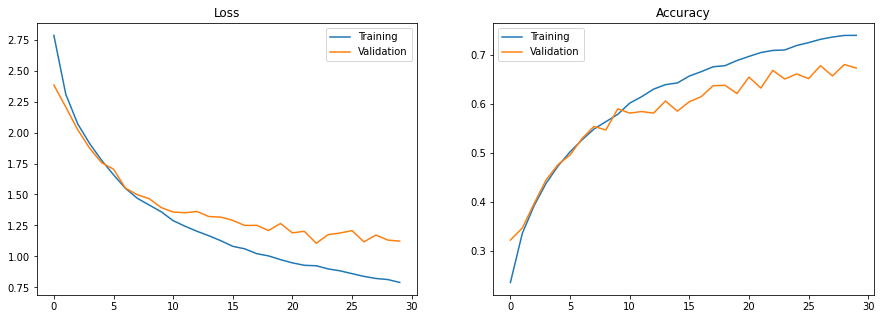

Estadísticas de BaseNetImproved (augment_normalize)
 - Test loss: 0.9379034042358398
 - Test accuracy: 0.7179999947547913


In [ ]:
_m[10] = BaseNetImproved()
_h[10], _s[10] = train(_m[10], *_cargar_dataset('cifar100'), get_datagenerator('augment_normalize', validation_split=.1), batch_size=32, n_epochs=30)
_mostrar_evolucion(_h[10])
_print_evaluate(_m[10], _s[10], 'augment_normalize')

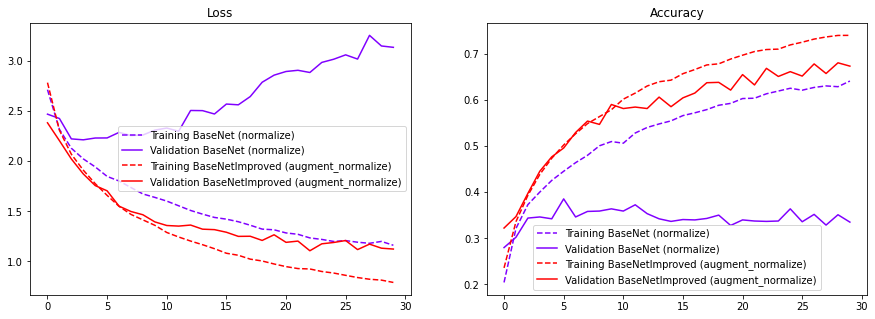

In [ ]:
_mostrar_evoluciones({'BaseNet (normalize)': _h[1], 'BaseNetImproved (augment_normalize)': _h[10]})

Vemos que hemos obtenido un modelo que consigue un rendimiento considerablemente mejor a `BaseNet`. De hecho, los _loss_ y _accuracies_ de validación de `BaseNetImproved` son mejores en todo momento a los de entrenamiento en `BaseNet`. Esto además podemos verlo en los _accuracy_ y _loss_ de test.

En conclusión, vemos cómo es muy importante considerar las mejoras que hemos analizado en este apartado a la hora de obtener un modelo de CNN con el mejor rendimiento posible. Es mediante una combinación de éstos que conseguiremos unos resultados mucho mejores.